### 🌪️ Proyecto de Predicción de Magnitud de Tornados con LSTM
- Fuente: kaggle.com
- URL: https://www.kaggle.com/datasets/danbraswell/us-tornado-dataset-1950-2021
- Fecha: 30 de Abril del 2025

### 0. Librerías

In [1]:
# 1. Librerías básicas y manejo de datos
import pickle
import logging
import pandas as pd
import numpy as np

# 2. Visualización de datos
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.graph_objects as go
import folium
from folium.plugins import MarkerCluster

# 3. Preprocesamiento y feature engineering
from sklearn.preprocessing import (
    MinMaxScaler,
    LabelEncoder,
    OneHotEncoder,
    OrdinalEncoder
)
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV

)
from sklearn.utils.class_weight import compute_class_weight, compute_sample_weight
from sklearn.pipeline import Pipeline

# 4. Modelos de Machine Learning
from sklearn.ensemble import (
    HistGradientBoostingClassifier,
    RandomForestClassifier,
    GradientBoostingClassifier
)
from sklearn.tree import DecisionTreeClassifier

# 5. Evaluación de modelos
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    matthews_corrcoef,
    classification_report,
    confusion_matrix,
    ConfusionMatrixDisplay
)
from sklearn.inspection import permutation_importance

# 6. Deep Learning
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

logger = logging.getLogger()
logger.setLevel(logging.ERROR)

2025-05-01 23:24:12.361345: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 23:24:12.622486: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-01 23:24:12.734525: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746141853.020622     648 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746141853.130962     648 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746141853.780048     648 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linkin

### 1. Introducción

En este proyecto desarrollamos modelos de Machine Learning y Deep Learning para predecir la magnitud de tornados en Estados Unidos, utilizando el conjunto de datos histórico US Tornado Dataset 1950–2021 (CSV).

### 2. Conceptos (Marco teórico)

#### 🌪️ Tornados: Definición, Clasificación e Impacto
---------     
##### **❓ ¿Qué es un tornado?**

**Un tornado** es una columna de aire que gira violentamente desde una tormenta eléctrica hasta la superficie terrestre.  

---------            

###### **- Características principales:**  

- Forma: A menudo de embudo característica  
- Vientos: Pueden oscilar entre 105 km/h y más de 322 km/h (65 a más de 200 mph), dependiendo de la intensidad del tornado.  
- Tamaño: Puede variar desde unos pocos metros hasta más de 2 kilómetros de ancho.
- Duración: Generalmente dura desde unos pocos segundos hasta más de una hora.
- Movimiento: Normalmente se desplaza a velocidades de 30 a 70 km/h, aunque puede variar.

            
###### **- Formación:**
              
- Aire cálido y húmedo en la superficie se encuentra con aire frío y seco en niveles superiores.
- Se desarrolla una tormenta supercelda con cizalladura del viento (cambios en la velocidad o dirección del viento con la altura).
- El aire ascendente (corrientes de ascenso) comienza a rotar debido a la cizalladura del viento.
- Esta rotación se estrecha y alarga, formando un embudo visible de nubes.
- Si el embudo toca el suelo, se convierte en un tornado.            

            
###### **- Línea de Tiempo de la Taxonomía**

Los tornados han sido clasificados de diferentes maneras a lo largo del tiempo. Desde 1958, han existido múltiples taxonomías que han evolucionado desde descripciones visuales simples hasta clasificaciones científicas más precisas. A lo largo de las décadas, se han introducido nuevas categorías y refinado definiciones para reflejar mejor la diversidad y formación de los tornados.            

            
- Antes de 1958: Sin sistema formal; basado en apariencia/daños.
- 1958: 3 especies — Embudo, Trombón de agua, Diablo de polvo.
- 2000: Se añadió Tromba terrestre (Landspout); definiciones refinadas.
- 2009: Cambio a 2 tipos — Supercelda y No Supercelda.
- 2013: 3 tipos — Supercelda, No Supercelda, Híbrido.


---------

#### **📊 Clasificaciónes de Tornados**       

Antes de 1971, no existía un sistema formal para clasificar tornados. En 1971, se introdujo la Escala Fujita (F), y en 2007 fue reemplazada en EE.UU. por la Escala Mejorada Fujita (EF), diseñada para evaluar con mayor precisión el daño y estimar mejor la velocidad del viento. El cambio se realizó porque la escala original sobreestimaba algunas velocidades del viento. Ambas escalas se basan en daños observados, pero la EF también considera el tipo de estructura afectada.
            
**Otras variables consideradas en la clasificación incluyen:**

- Velocidad estimada del viento
-Tipo de edificaciones o vegetación dañadas
-Trayectoria y duración del tornado
-Ancho del recorrido de daño            

---------

            
##### *****- Escala Fujita Original (F) (1971)*****

| Categoría | Velocidad Viento | Daños |
|-----------|------------------|-------|
| **F0** | 40-72 mph (64-116 km/h) | Leves (ramas rotas, señales dobladas) |
| **F1** | 73-112 mph (117-180 km/h) | Moderados (tejas voladas, caravanas volcadas) |
| **F2** | 113-157 mph (181-253 km/h) | Considerables (techos arrancados, árboles arrancados) |
| **F3** | 158-206 mph (254-332 km/h) | Graves (estructuras débiles destruidas) |
| **F4** | 207-260 mph (333-418 km/h) | Devastadores (casas niveladas, autos lanzados) |
| **F5** | 261-318 mph (419-512 km/h) | Increíbles (estructuras arrasadas, deformación del terreno) |
            
##### *****- Escala Mejorada Fujita (EF) (2007 – EE.UU.)*****
| Categoría | Velocidad Viento | Daños |
|-----------|------------------|-------|
| **EF0** | 65-85 mph (105-137 km/h) | Leves (ramas rotas) |
| **EF1** | 86-110 mph (138-177 km/h) | Moderados (tejados dañados) |
| **EF2** | 111-135 mph (178-217 km/h) | Considerables (árboles arrancados) |
| **EF3** | 136-165 mph (218-266 km/h) | Graves (paredes derrumbadas) |
| **EF4** | 166-200 mph (267-322 km/h) | Devastadores (casas destruidas) |
| **EF5** | >200 mph (322+ km/h) | Increíbles (estructuras arrasadas) |
            

---------
            
#### **💰 Impacto Económico**
##### **- Factores clave:**  
- **Categoría del tornado** (EF3+ = mayor destrucción)  
- **Ubicación** (zonas urbanas = mayor costo)  

##### **- Áreas afectadas:**  
- 🏠 Viviendas e infraestructuras  
- 🌾 Agricultura (cosechas/ganado)  
- 🏢 Negocios (interrupciones operativas)  
- 🚑 Respuesta de emergencia  

##### **- Ejemplos destacados (EE.UU.)**
| Evento | Año | Daños (USD) | Categoría |
|--------|-----|-------------|-----------|
| Joplin, MO | 2011 | $2.8 mil millones | EF5 |
| Moore, OK | 2013 | $2 mil millones | EF5 |
| **Promedio anual (1996-2023)** | - | **$1.1 mil millones** | EF3-EF4 |  


> **Dato crítico:** Un EF2 en zona urbana puede costar más que un EF4 en área rural.


### 3. Hipótesis

La intensidad de un tornado puede predecirse con precisión utilizando un modelo de aprendizaje automático entrenado con variables categóricas como el mes, el estado, la región y la estación del año, así como variables numéricas como la latitud y longitud de inicio, la longitud del trayecto y el ancho del tornado. Se espera que entre todas estas, la época del año y la ubicación geográfica tengan una influencia especialmente significativa en la magnitud del tornado.

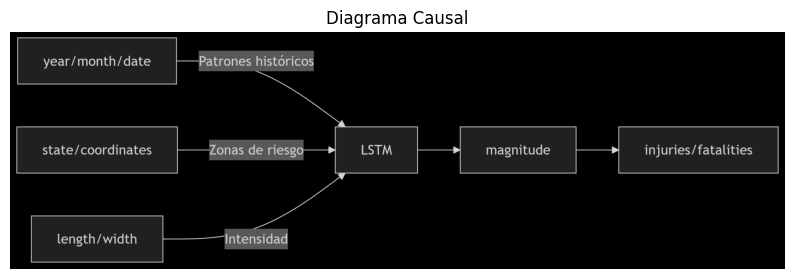

In [2]:
diag_causal = mpimg.imread('../diagrama_causal.png') 

# Mostrar imagen
plt.figure(figsize=(10, 6))  
plt.imshow(diag_causal)
plt.axis('off') 
plt.title('Diagrama Causal')
plt.show()

### 4. Preprocesamiento

##### Dataset
-----------
            
##### 🗂️ US Tornado Dataset 1950-2021
Utilizamos un conjunto de datos obtenido de Kaggle.com, que recopila información sobre tornados ocurridos en Estados Unidos desde 1950 hasta 2021. Este dataset incluye variables como la fecha, ubicación, intensidad, longitud, ancho, y daños causados por cada tornado reportado. Gracias a su amplitud temporal y nivel de detalle, nos permitió analizar tendencias históricas y comparar la severidad de los eventos a lo largo del tiempo.

-----------

##### ***Diccionario de Datos***

|Nombre|Descripción|Tipo|
|----|-----------|----|
|year|Año con 4 dígitos|Int|
|month|Mes (1-12)|Int|
|day|Día del mes|Int|
|date|Objeto datetime (ej. 2011-01-01)|Date|
|state|Estado donde se originó el tornado; abreviatura de 2 letras|String|
|magnitude|Escala Fujita mejorada para clasificar tornados|Int|
|injuries|Número de heridos durante el tornado|Int|
|fatalities|Número de fallecidos durante el tornado|Int|
|start_latitude|Latitud inicial en grados decimales|Float|
|start_longitude|Longitud inicial en grados decimales|Float|
|end_latitude|Latitud final en grados decimales|Float|
|end_longitude|Longitud final en grados decimales|Float|
|length|Longitud de la trayectoria en millas|Float|
|width|Ancho en yardas|Float|

##### **📋 Resumen de pasos:**

- Filtramos los datos para incluir solo los tornados ocurridos a partir de febrero de 2007.

- Eliminamos los registros con magnitudes inválidas (-9, 4 y 5).

- Contamos los tornados por estado y nos quedamos solo con los estados que tienen al menos 50 registros.

- Eliminamos las filas con valores cero en longitud, ancho o latitud final, ya que indican datos incompletos.

- Eliminamos filas duplicadas para evitar repeticiones en el entrenamiento del modelo.

- Convertimos la columna de fecha al formato datetime y ordenamos los datos cronológicamente.

- Reiniciamos los índices del DataFrame para mantener un orden limpio.

- Renombramos las columnas para hacerlas más intuitivas y legibles.

- Agrupamos los estados en cuatro regiones geográficas de EE.UU. (este, sur, medio oeste y oeste) y creamos la columna region.

- Creamos la columna season según el mes del año en que ocurrió cada tornado (invierno, primavera, verano u otoño).

- Convertimos las columnas magnitude, state, region y season en variables categóricas para optimizar el uso de memoria.  

##### ***📊 Muestra del DataFrame Final***

In [3]:
df_raw = pd.read_csv('../data/raw/us_tornado_dataset_1950_2021.csv')
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 67558 entries, 0 to 67557
Data columns (total 14 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   yr      67558 non-null  int64  
 1   mo      67558 non-null  int64  
 2   dy      67558 non-null  int64  
 3   date    67558 non-null  object 
 4   st      67558 non-null  object 
 5   mag     67558 non-null  int64  
 6   inj     67558 non-null  int64  
 7   fat     67558 non-null  int64  
 8   slat    67558 non-null  float64
 9   slon    67558 non-null  float64
 10  elat    67558 non-null  float64
 11  elon    67558 non-null  float64
 12  len     67558 non-null  float64
 13  wid     67558 non-null  int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 7.2+ MB


In [5]:
df_raw.sample(10, random_state=2025)

,yr,mo,dy,date,st,mag,inj,fat,slat,slon,elat,elon,len,wid
44528,2003,6,4,2003-06-04,NM,0,0,0,36.65,-104.13,36.65,-104.13,0.50,100
25316,1985,8,31,1985-08-31,FL,1,0,0,28.25,-82.72,0.00,0.00,0.50,10
31651,1992,8,29,1992-08-29,FL,0,0,0,26.68,-80.05,0.00,0.00,0.10,10
23045,1983,4,23,1983-04-23,WA,0,0,0,46.90,-119.07,0.00,0.00,0.50,33
47201,2005,5,11,2005-05-11,IL,0,0,0,40.00,-91.17,40.00,-91.17,0.20,50
51002,2008,5,5,2008-05-05,TX,0,0,0,31.28,-102.65,31.31,-102.63,2.28,50
17846,1977,4,19,1977-04-19,TX,0,0,0,33.85,-98.83,0.00,0.00,0.10,10
50080,2007,6,29,2007-06-29,CO,0,0,0,38.04,-105.47,38.03,-105.47,1.00,75
24505,1984,7,5,1984-07-05,MA,1,0,0,42.50,-72.33,0.00,0.00,2.00,80
26125,1986,10,1,1986-10-01,WV,3,1,0,39.30,-80.78,0.00,0.00,1.00,200


In [4]:
df_baking = df_raw.copy()
df_baking = df_baking[df_baking['date'] > "2007-01-31"] #Tomamos la data de Febrero 2007 en adelante
df_baking = df_baking[(df_baking['mag'] != -9) & (df_baking['mag'] != 5) & (df_baking['mag'] !=4)] #Eliminamos filas sin magnitud y magnitud 4 y 5
conteo_states = df_baking['st'].value_counts()
estados_validos = conteo_states[conteo_states >= 50].index
df_baking = df_baking[df_baking['st'].isin(estados_validos)]
df_baking = df_baking[(df_baking['len'] != 0) & (df_baking['wid'] != 0) & (df_baking["elat"] != 0)] ##Eliminamos filas sin trayecto o ancho conocidos
df_baking.drop_duplicates(inplace=True) #Eliminamos filas duplicadas
df_baking['date'] = pd.to_datetime(df_baking['date']) #Convertimos columna date en tipo Date
df_baking = df_baking.sort_values('date') #Ordenamos por orden cronologico
df_baking.reset_index(drop=True, inplace=True) #Reinciamos Indices 
df_baking.rename(columns={"yr": "year", "mo": "month", "dy": "day", "date": "date", "st": "state", "mag": "magnitude",
                          "inj": "injuries", "fat": "fatalities", "slat": "start_latitude", "slon": "start_longitude",
                          "elat": "end_latitude", "elon": "end_longitude","len": "length", "wid": "width"}, inplace=True)

#CREATING NEW COLUMN FOR US REGION
ne = ['CT', 'ME', 'MA', 'NH', 'RI', 'VT', 'NJ', 'NY', 'PA']
s = ['DE', 'MD', 'VA', 'WV', 'NC', 'SC', 'GA', 'FL', 'KY', 'TN', 'AL', 'MS', 'LA', 'TX','DC']
mw = ['IL', 'IN', 'IA', 'KS', 'MI', 'MN', 'MO', 'NE', 'ND', 'OH', 'SD', 'WI']
w = ['AZ', 'CA', 'CO', 'ID', 'MT', 'NV', 'NM', 'OR', 'UT', 'WA', 'WY']

regions = []


for state in df_baking['state']:
    if state in ne:
        region = 'e'
    elif state in s:
        region = 's'
    elif state in mw:
        region = 'mw'
    elif state in w:
        region = 'w'
    else:
        region = 'Unknown'  # For states not in any region

    regions.append(region)

df_baking['region'] = regions


#Months into seasons:
Winter = (12, 1, 2)
Spring = (3, 4, 5)
Summer = (6, 7, 8)
Fall = (9, 10, 11)
seasons = []
for month in df_baking['month']:
    if month in Winter:
        current_season = 'Winter'
    elif month in Spring:
        current_season = 'Spring'
    elif month in Summer:
        current_season = 'Summer'
    elif month in Fall:
        current_season = 'Fall'
    else:
        current_season = 'Unknown'
    seasons.append(current_season)
df_baking['season'] = seasons
df_baking['season'] = df_baking['season'].astype('category')


df_baking['magnitude'] = df_baking['magnitude'].astype('category')
df_baking['state'] = df_baking['state'].astype('category')
df_baking['region'] = df_baking['region'].astype('category')
df_baking.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16880 entries, 0 to 16879
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year             16880 non-null  int64         
 1   month            16880 non-null  int64         
 2   day              16880 non-null  int64         
 3   date             16880 non-null  datetime64[ns]
 4   state            16880 non-null  category      
 5   magnitude        16880 non-null  category      
 6   injuries         16880 non-null  int64         
 7   fatalities       16880 non-null  int64         
 8   start_latitude   16880 non-null  float64       
 9   start_longitude  16880 non-null  float64       
 10  end_latitude     16880 non-null  float64       
 11  end_longitude    16880 non-null  float64       
 12  length           16880 non-null  float64       
 13  width            16880 non-null  int64         
 14  region           16880 non-null  categ

In [5]:
df = df_baking.copy()

### 5. Análisis Exploratorio de Datos

In [9]:
df_train = df.iloc[:14741,:] # 85% del dataset para df_train
df_val = df.iloc[14741:15810,:] # 7.5% del dataset para df_val
df_test = df.iloc[15810:,:] # 7.5% del dataset para df_test

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_train.shape, df_val.shape, df_test.shape

((14741, 16), (1069, 16), (1070, 16))

##### ***Frecuencia de Tornados por Mes del 2007 al 2021***
            
Este barplot muestra visualmente cuántos tornados ocurrieron en cada mes, lo que nos permite analizar las tendencias a lo largo del año. Al observar el barplot, podemos notar que mayo tiende a tener una mayor concentración de tornados en comparación con otros meses. Este patrón sugiere que mayo podría ser un mes especialmente activo para la ocurrencia de tornados, lo que podría estar relacionado con condiciones climáticas específicas durante esa temporada.

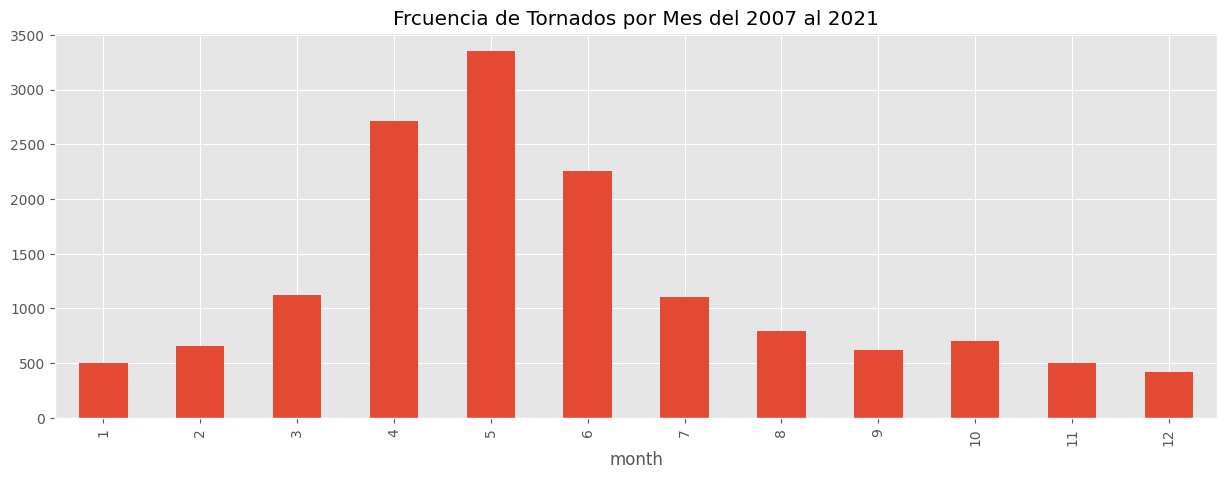

In [10]:
plt.style.use('ggplot');
plt.title('Frcuencia de Tornados por Mes del 2007 al 2021')
df_train['month'].value_counts().sort_index().plot(kind='bar', figsize=(15, 5))
plt.show()

##### ***Frecuencia de Tornados por Estado del 2007 al 2021***

Este barplot muestra la frecuencia de tornados por estado entre 2007 y 2021. El gráfico presenta la cantidad de tornados ocurridos en cada estado, y los colores de las barras se utilizan para representar diferentes rangos de frecuencia:

- Las barras rojas indican estados con más de 1000 tornados.
- Las barras naranjas representan estados con entre 400 y 1000 tornados.
- Las barras verdes indican estados con menos de 400 tornados.

Además, se han añadido líneas horizontales (líneas discontinuas) para marcar los umbrales de 1000 y 400 tornados, destacando visualmente las diferencias significativas entre los estados con alta, media y baja cantidad de tornados.

El gráfico nos permite observar rápidamente qué estados han sido más afectados por tornados, destacando especialmente aquellos con una frecuencia notablemente alta, lo que puede indicar regiones más propensas a este fenómeno climático. Los estados más afectados por tornados incluyen **Texas, Kansas, Oklahoma, Alabama, Mississippi, Missouri, Louisiana, Illinois, Iowa, Minnesota, Nebraska, Florida, Georgia, Colorado, Arkansas y Kentucky**.



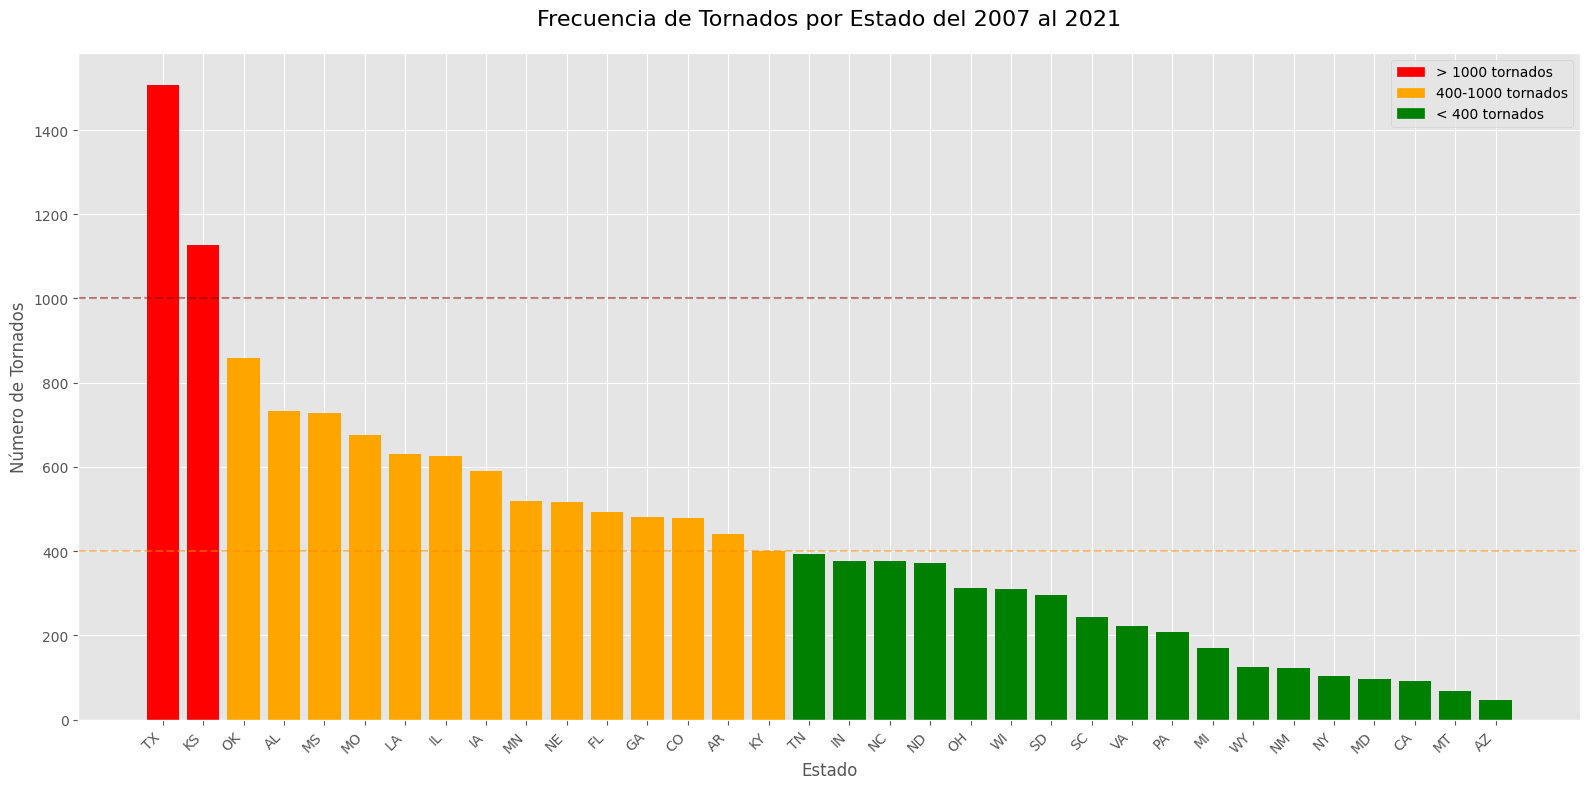

In [11]:
state_counts = df_train['state'].value_counts().sort_values(ascending=False)

colors = []
for count in state_counts:
    if count > 1000:
        colors.append('red')
    elif 400 <= count <= 1000:
        colors.append('orange')
    else:
        colors.append('green')

plt.figure(figsize=(16, 8))
bars = plt.bar(state_counts.index, state_counts.values, color=colors)

plt.title('Frecuencia de Tornados por Estado del 2007 al 2021', fontsize=16, pad=20)
plt.xlabel('Estado', fontsize=12)
plt.ylabel('Número de Tornados', fontsize=12)
plt.xticks(rotation=45, ha='right')

plt.axhline(y=1000, color='darkred', linestyle='--', alpha=0.5)
plt.axhline(y=400, color='darkorange', linestyle='--', alpha=0.5)

legend_elements = [
    mpatches.Patch(color='red', label='> 1000 tornados'),
    mpatches.Patch(color='orange', label='400-1000 tornados'),
    mpatches.Patch(color='green', label='< 400 tornados')
]
plt.legend(handles=legend_elements, loc='upper right')

plt.tight_layout()
plt.show()

##### ***Mapa Interactivo de Tornados por Año***

Este mapa interactivo permite seleccionar un año específico y visualizar las concentraciones de tornados ocurridos en ese periodo. Al filtrar los datos por año, podemos observar las ubicaciones de los tornados y sus trayectorias, lo que ofrece una nueva forma de analizar la distribución y frecuencia de estos fenómenos meteorológicos.

Optamos por trabajar con los datos año por año en lugar de intentar una animación con todos los años simultáneamente para evitar la sobrecarga de datos. Esto nos permite obtener una visión más clara y manejable de las concentraciones de tornados sin perder detalles importantes.

Este enfoque facilita el análisis de patrones y tendencias en los tornados, lo que puede ser útil para la toma de decisiones en estudios meteorológicos y gestión de riesgos.

In [12]:
# Filtrar por año
year_filter  = 2019
df_filtered = df_train[df_train['year'] == year_filter].copy()  # Cambia el año según necesites

# Mapa
map = folium.Map(location=[39.8283, -98.5795], zoom_start=4)

# Agrupamiento de marcadores
marker_cluster = MarkerCluster().add_to(map)

# Añadir elementos en lotes o grupos
for coords in df_filtered[['start_latitude', 'start_longitude']].values:
    folium.CircleMarker(
        location=coords,
        radius=3,
        color='green',
        fill=True
    ).add_to(marker_cluster)

for coords in df_filtered[['end_latitude', 'end_longitude']].values:
    folium.CircleMarker(
        location=coords,
        radius=3,
        color='red',
        fill=True
    ).add_to(marker_cluster)

#Líneas de trayectoria
for _, row in df_filtered.iterrows():
    folium.PolyLine(
        locations=[(row['start_latitude'], row['start_longitude']), 
                  (row['end_latitude'], row['end_longitude'])],
        color='blue',
        weight=1
    ).add_to(map)

map

### 6. Desarrollo del Modelo de Machine Learning

Probamos múltiples modelos de aprendizaje automático para predecir la magnitud de los terremotos. Los tres modelos que evaluamos fueron:

- **LSTM (Long Short-Term Memory)**
- **Gradient Boosting**
- **Random Forest**

Todos los modelos fueron probados utilizando el mismo conjunto de parámetros de entrada:
- `month`
- `state`
- `region`
- `start latitude`
- `start longitude`
- `length`
- `width`

La **variable objetivo** para todos los modelos fue:
- `magnitude`

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14741 entries, 0 to 14740
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   year             14741 non-null  int64         
 1   month            14741 non-null  int64         
 2   day              14741 non-null  int64         
 3   date             14741 non-null  datetime64[ns]
 4   state            14741 non-null  category      
 5   magnitude        14741 non-null  category      
 6   injuries         14741 non-null  int64         
 7   fatalities       14741 non-null  int64         
 8   start_latitude   14741 non-null  float64       
 9   start_longitude  14741 non-null  float64       
 10  end_latitude     14741 non-null  float64       
 11  end_longitude    14741 non-null  float64       
 12  length           14741 non-null  float64       
 13  width            14741 non-null  int64         
 14  region           14741 non-null  categ

In [18]:
# Codificar 'magnitude' usando LabelEncoder
label_encoder = LabelEncoder()

df_train.loc[:, 'magnitude_encoded'] = label_encoder.fit_transform(df_train['magnitude'])
df_val.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_val['magnitude'])
df_test.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_test['magnitude'])

# Codificar 'month' usando OrdinalEncoder
ordinal_encoder = OrdinalEncoder()

df_train.loc[:, 'month_encoded'] = ordinal_encoder.fit_transform(df_train[['month']])
df_val.loc[:, 'month_encoded'] = ordinal_encoder.transform(df_val[['month']])
df_test.loc[:, 'month_encoded'] = ordinal_encoder.transform(df_test[['month']])

# Codificar 'season' usando OrdinalEncoder
df_train.loc[:, 'season_encoded'] = ordinal_encoder.fit_transform(df_train[['season']])
df_val.loc[:, 'season_encoded'] = ordinal_encoder.transform(df_val[['season']])
df_test.loc[:, 'season_encoded'] = ordinal_encoder.transform(df_test[['season']])

# Codificar 'region' usando OrdinalEncoder
df_train.loc[:, 'region_encoded'] = ordinal_encoder.fit_transform(df_train[['region']])
df_val.loc[:, 'region_encoded'] = ordinal_encoder.transform(df_val[['region']])
df_test.loc[:, 'region_encoded'] = ordinal_encoder.transform(df_test[['region']])




# Verifica que las columnas se hayan agregado correctamente
print(df_train[['magnitude', 'magnitude_encoded', 'month', 'month_encoded']].head())

# Características a escalar (sin la columna 'month' original)
features = ['month_encoded', 'start_latitude', 'start_longitude','length', 'width']

# Escalamos las características
scaler = MinMaxScaler()

# Escalar los datos (fit en el set de entrenamiento y transformar en el de validación y test)
train_scaled = scaler.fit_transform(df_train[features])  # solo fit en el set de entrenamiento
val_scaled = scaler.transform(df_val[features])
test_scaled = scaler.transform(df_test[features])

  magnitude  magnitude_encoded  month  month_encoded
0         0                  0      2            1.0
1         1                  1      2            1.0
2         3                  3      2            1.0
3         3                  3      2            1.0
4         1                  1      2            1.0


/tmp/ipykernel_2729/3778704670.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train.loc[:, 'magnitude_encoded'] = label_encoder.fit_transform(df_train['magnitude'])
/tmp/ipykernel_2729/3778704670.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val.loc[:, 'magnitude_encoded'] = label_encoder.transform(df_val['magnitude'])
/tmp/ipykernel_2729/3778704670.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = val

In [19]:
def secuencias(dataset, n_steps):
    X = []
    for i in range(len(dataset) - n_steps):
        X.append(dataset[i:i+n_steps, :])  
    return np.array(X)

In [20]:
# Crear las secuencias (X, y) para entrenamiento, validación y test
n_steps = 20  # Número de filas  para las secuencias
X_train = secuencias(train_scaled, n_steps)
X_val = secuencias(val_scaled, n_steps)
X_test = secuencias(test_scaled, n_steps)

# Asignar las etiquetas (magnitude_encoded) como target
y_train = df_train['magnitude_encoded'].values[n_steps:]
y_val = df_val['magnitude_encoded'].values[n_steps:]
y_test = df_test['magnitude_encoded'].values[n_steps:]

In [21]:
# Calcular los pesos para las clases de y_train
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train), 
                                     y=y_train)

# Convertir a diccionario para usarlo en el modelo
class_weight_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weight_dict)

Pesos de clase: {0: np.float64(0.4565500558243394), 1: np.float64(0.7375250501002004), 2: np.float64(2.7775471698113208), 3: np.float64(10.667391304347825)}


In [22]:
# Crear el modelo
lstm_tornado = Sequential()

# Capa de entrada: (n_steps, 3 features)
lstm_tornado.add(Input(shape=(X_train.shape[1], X_train.shape[2])))  # (20, 3)

# Capa LSTM
lstm_tornado.add(LSTM(units=100, return_sequences=False))

# Capa Dropout para evitar sobreajuste
lstm_tornado.add(Dropout(0.2))

# Número de clases (magnitudes únicas)
n_classes = len(np.unique(y_train))

# Capa de salida: clasificación multiclase
lstm_tornado.add(Dense(n_classes, activation='softmax'))  # Softmax para clasificación

# Resumen del modelo
lstm_tornado.summary()


2025-05-01 03:53:34.252580: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 100)            │        42,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           404 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 42,804 (167.20 KB)

 Trainable params: 42,804 (167.20 KB)

 Non-trainable params: 0 (0.00 B)

In [23]:
# Compilar el modelo
lstm_tornado.compile(optimizer='adam', 
                     loss='sparse_categorical_crossentropy',  # Correcto para y en formato entero
                     metrics=['accuracy'])


In [24]:
# EarlyStopping para evitar overfitting
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Entrenar el modelo

y_hat_lstm = lstm_tornado.fit(X_train, y_train, 
                              epochs=50, 
                              batch_size=32, 
                              validation_data=(X_val, y_val), 
                              callbacks=[early_stop],
                              class_weight=class_weight_dict)


Epoch 1/50


461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.2587 - loss: 1.4127 - val_accuracy: 0.3494 - val_loss: 1.3437
Epoch 2/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4250 - loss: 1.3410 - val_accuracy: 0.3003 - val_loss: 1.3943
Epoch 3/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4335 - loss: 1.3130 - val_accuracy: 0.3022 - val_loss: 1.4052
Epoch 4/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step - accuracy: 0.4322 - loss: 1.3310 - val_accuracy: 0.3051 - val_loss: 1.4279
Epoch 5/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4495 - loss: 1.3089 - val_accuracy: 0.3292 - val_loss: 1.4109
Epoch 6/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4432 - loss: 1.3182 - val_accuracy: 0.3648 - val_loss: 1.3502
Epoch 7/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - accuracy: 0.4564 - loss: 1.3038 - val_accuracy: 0.2416 - val_loss: 1.5380
Epoch 8/50
461/461 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - accuracy: 0.4455 - loss: 1.3188 - val_accuracy: 0.3725 - val_

In [25]:
# Evaluar el modelo en el conjunto de test
test_loss, test_acc = lstm_tornado.evaluate(X_test, y_test)

# Imprimir la pérdida y precisión en el conjunto de test
print(f"Test loss: {test_loss}")
print(f"Test accuracy: {test_acc}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.4366 - loss: 1.2681
Test loss: 1.2077420949935913
Test accuracy: 0.47924527525901794


In [26]:
# Predicciones sobre el conjunto de test
y_hat_lstm = lstm_tornado.predict(X_test)
y_hat_class = np.argmax(y_hat_lstm, axis=1)  # Para obtener las clases predichas

# Imprimir el reporte de clasificación
print("Modelo LSTM")
print(classification_report(y_test, y_hat_class))

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


Modelo LSTM
              precision    recall  f1-score   support

           0       0.57      0.73      0.64       527
           1       0.48      0.26      0.34       411
           2       0.25      0.10      0.14       103
           3       0.06      0.37      0.10        19

    accuracy                           0.48      1060
   macro avg       0.34      0.36      0.30      1060
weighted avg       0.49      0.48      0.46      1060



In [27]:
# Restaurar 'magnitude'
df_train['magnitude'] = label_encoder.inverse_transform(df_train['magnitude_encoded'])
df_val['magnitude'] = label_encoder.inverse_transform(df_val['magnitude_encoded'])
df_test['magnitude'] = label_encoder.inverse_transform(df_test['magnitude_encoded'])

# Restaurar 'month'
#df_train['month'] = ordinal_encoder.inverse_transform(df_train[['month_encoded']])
#df_val['month'] = ordinal_encoder.inverse_transform(df_val[['month_encoded']])
#df_test['month'] = ordinal_encoder.inverse_transform(df_test[['month_encoded']])


/tmp/ipykernel_2729/1512388511.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train['magnitude'] = label_encoder.inverse_transform(df_train['magnitude_encoded'])
/tmp/ipykernel_2729/1512388511.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val['magnitude'] = label_encoder.inverse_transform(df_val['magnitude_encoded'])
/tmp/ipykernel_2729/1512388511.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value

34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


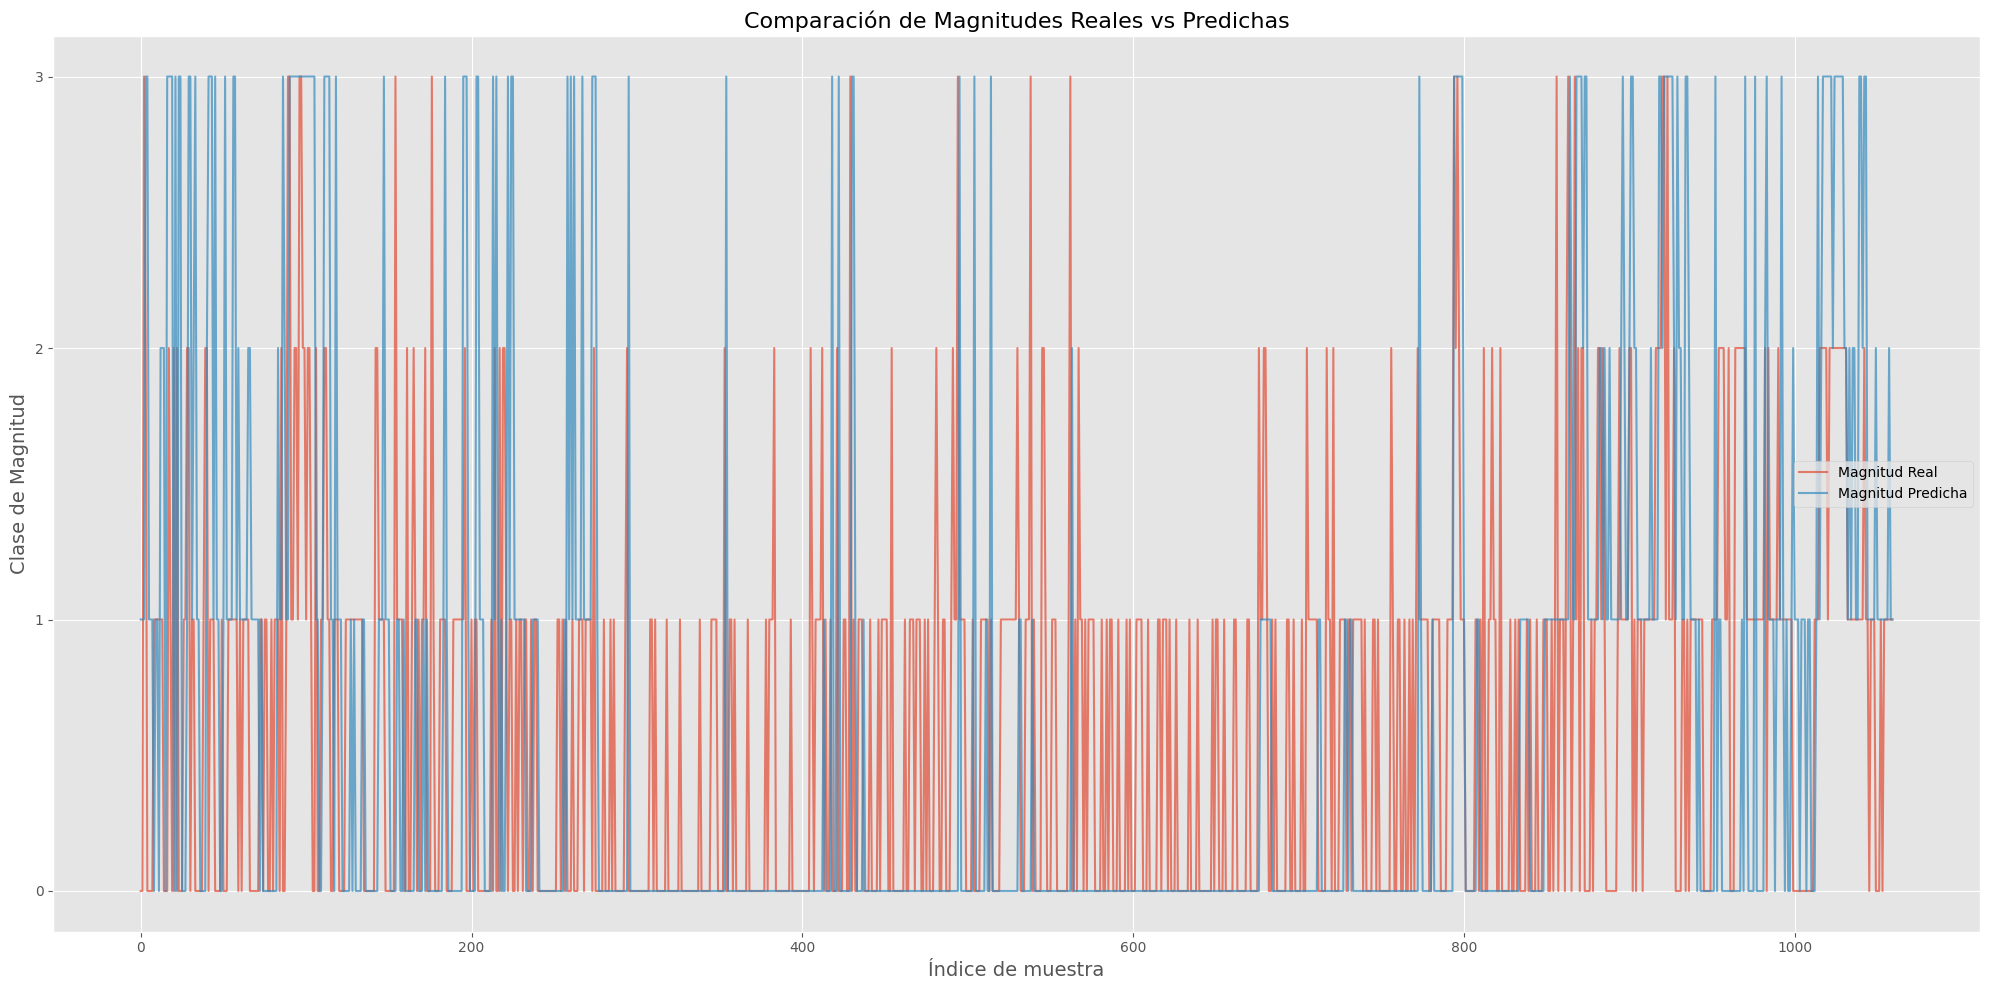

In [28]:
# Predicciones sobre el conjunto de test
predicciones = lstm_tornado.predict(X_test)

# Convertir predicciones probabilísticas a clases
y_hat_classes = np.argmax(predicciones, axis=1)

# Crear el gráfico
plt.figure(figsize=(20, 10))
plt.plot(y_test, label='Magnitud Real', alpha=0.7)
plt.plot(y_hat_classes, label='Magnitud Predicha', alpha=0.7)
plt.title('Comparación de Magnitudes Reales vs Predichas', fontsize=16)
plt.xlabel('Índice de muestra', fontsize=14)
plt.ylabel('Clase de Magnitud', fontsize=14)

# Escala en el eje Y en pasos de 1
plt.yticks(np.arange(min(y_test.min(), y_hat_classes.min()), 
                     max(y_test.max(), y_hat_classes.max()) + 1, 
                     1))

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### 7. Comparacion de modelos

#### Gradient Boosting

In [14]:
df = df_baking.copy()

In [17]:
#Train + Temp (val + test)
df_train, df_temp = train_test_split(df, test_size=0.2,
                                     random_state=2025,
                                     stratify=df['magnitude'])

#Val + Test
df_val, df_test = train_test_split(df_temp, test_size=0.5,
                                   random_state=2025,
                                   stratify=df_temp['magnitude'])

#Reindexado
df_train_gb = df_train.reset_index(drop=True)
df_val_gb = df_val.reset_index(drop=True)
df_test_gb = df_test.reset_index(drop=True)

print(df_train.shape, df_val.shape, df_test.shape)

(13504, 16) (1688, 16) (1688, 16)


In [19]:
df_train_gb = df_train.copy()
df_val_gb = df_val.copy()
df_test_gb = df_test.copy()

# Columnas categóricas que vamos a codificar
categorical_cols = ['month', 'state', 'region', 'season']

# Crear y aplicar el OrdinalEncoder
ordinal_encoder_gb = OrdinalEncoder()

# Fit en entrenamiento, transform en los 3 conjuntos
df_train_gb[categorical_cols] = ordinal_encoder_gb.fit_transform(df_train_gb[categorical_cols])
df_val_gb[categorical_cols]   = ordinal_encoder_gb.transform(df_val_gb[categorical_cols])
df_test_gb[categorical_cols]  = ordinal_encoder_gb.transform(df_test_gb[categorical_cols])


In [20]:
# Variables
categorical_cols = ['month', 'state', 'region', 'season']
numeric_cols = ['start_latitude', 'start_longitude', 'length', 'width']
target = 'magnitude'

# Columnas finales para el modelo
feature_cols = categorical_cols + numeric_cols

# Sets de entrenamiento, validación y prueba
X_train_gb = df_train_gb[feature_cols]
y_train_gb = df_train_gb[target]

X_val_gb = df_val_gb[feature_cols]
y_val_gb = df_val_gb[target]

X_test_gb = df_test_gb[feature_cols]
y_test_gb = df_test_gb[target]

In [21]:
# Calcular los pesos por clase
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_gb),
                                     y=y_train_gb)

# Convertir a diccionario
class_weight_dict = dict(enumerate(class_weights))
print("Pesos de clase:", class_weight_dict)

# Generar pesos para cada muestra del set de entrenamiento
sample_weights = compute_sample_weight(class_weight=class_weight_dict, y=y_train_gb)

# Definir y entrenar el modelo base
clf_gb = HistGradientBoostingClassifier(random_state=2025)
clf_gb.fit(X_train_gb, y_train_gb, sample_weight=sample_weights)

Pesos de clase: {0: np.float64(0.4638636988183567), 1: np.float64(0.7202901642841903), 2: np.float64(2.7536704730831976), 3: np.float64(10.78594249201278)}


HistGradientBoostingClassifier(random_state=2025)

Reporte de Clasificación (Modelo Base Gradient Boosting):
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       910
           1       0.58      0.54      0.56       586
           2       0.27      0.40      0.32       153
           3       0.25      0.56      0.34        39

    accuracy                           0.64      1688
   macro avg       0.48      0.57      0.51      1688
weighted avg       0.68      0.64      0.66      1688



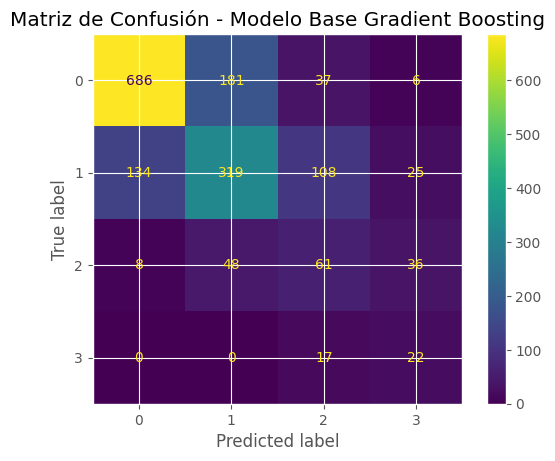

In [22]:
# Predicciones en test
y_hat_gb = clf_gb.predict(X_test_gb)

# Classification Report
print("Reporte de Clasificación (Modelo Base Gradient Boosting):")
print(classification_report(y_test_gb, y_hat_gb))

# Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(y_test_gb, y_hat_gb)
plt.title("Matriz de Confusión - Modelo Base Gradient Boosting")
plt.show()

In [25]:
#Ajuste del modelo

# Modelo base
gb_base = HistGradientBoostingClassifier(random_state=2025)

# Grilla compacta pero efectiva
param_grid = {
    'learning_rate': [0.05, 0.1],
    'max_iter': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_leaf': [20, 50]
}

In [26]:
grid_search_gb = GridSearchCV(
    estimator=gb_base,
    param_grid=param_grid,
    scoring='f1_macro',
    cv=3,
    verbose=2,
    n_jobs=-1
)

# Ejecutar búsqueda con sample_weight
grid_search_gb.fit(X_train_gb, y_train_gb, sample_weight=sample_weights)

Fitting 3 folds for each of 24 candidates, totalling 72 fits
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   2.5s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   2.5s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=20; total time=   1.8s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   2.0s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   3.4s
[CV] END learning_rate=0.05, max_depth=None, max_iter=100, min_samples_leaf=50; total time=   3.2s
[CV] END learning_rate=0.05, max_depth=None, max_iter=200, min_samples_leaf=20; total time=   5.6s
[CV] END learning_rate=0.05, max_depth=None, max_iter=200, min_samples_leaf=20; total time=   5.8s
[CV] END learning_rate=0.05, max_depth=None, max_iter=200, min_samples_leaf=20; total time=   5.1s
[CV] END learning_rate=0.05, max_depth=None, max

GridSearchCV(cv=3, estimator=HistGradientBoostingClassifier(random_state=2025),
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1],
                         'max_depth': [None, 10, 20], 'max_iter': [100, 200],
                         'min_samples_leaf': [20, 50]},
             scoring='f1_macro', verbose=2)

In [28]:
#Mejores Parametros
best_clf_gb = grid_search_gb.best_estimator_
print("Mejores hiperparámetros encontrados:")
print(grid_search_gb.best_params_)

Mejores hiperparámetros encontrados:
{'learning_rate': 0.1, 'max_depth': None, 'max_iter': 200, 'min_samples_leaf': 20}


Reporte de Clasificación (Modelo Optimizado Gradient Boosting):
              precision    recall  f1-score   support

           0       0.83      0.75      0.79       910
           1       0.58      0.54      0.56       586
           2       0.27      0.40      0.32       153
           3       0.25      0.56      0.34        39

    accuracy                           0.64      1688
   macro avg       0.48      0.57      0.51      1688
weighted avg       0.68      0.64      0.66      1688



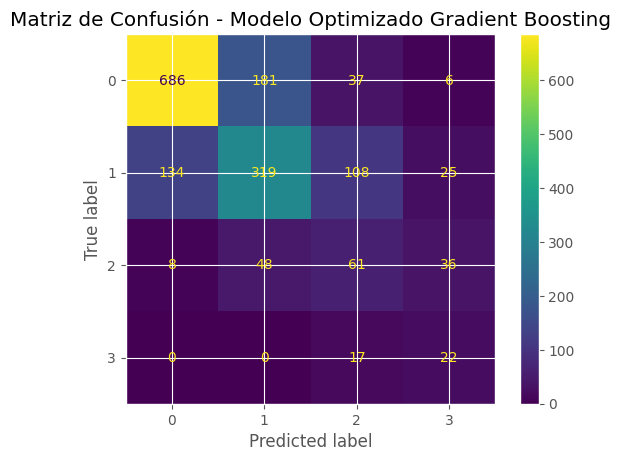

In [29]:
# Predicciones sobre el test set
y_hat_best_gb = best_clf_gb.predict(X_test_gb)

# Reporte de clasificación
print("Reporte de Clasificación (Modelo Optimizado Gradient Boosting):")
print(classification_report(y_test_gb, y_hat_best_gb))

# Matriz de confusión
ConfusionMatrixDisplay.from_predictions(y_test_gb, y_hat_best_gb)
plt.title("Matriz de Confusión - Modelo Optimizado Gradient Boosting")
plt.show()

#### Raining Forest

In [30]:
# Variables
categorical_cols = ['month', 'state', 'region', 'season']
numeric_cols = ['start_latitude', 'start_longitude', 'length', 'width']
target = 'magnitude'

# Features y target
features_rf = categorical_cols + numeric_cols
target_rf = target

# Copias de trabajo
X_train_rf = df_train[features_rf].copy()
X_test_rf = df_test[features_rf].copy()

y_train_rf = df_train[target_rf].copy()
y_test_rf = df_test[target_rf].copy()

# One-hot encoding para las variables categóricas (eliminar la primera para evitar multicolinealidad)
X_train_rf = pd.get_dummies(X_train_rf, columns=categorical_cols, drop_first=True)
X_test_rf = pd.get_dummies(X_test_rf, columns=categorical_cols, drop_first=True)

# Label encoding para la variable objetivo
label_encoder_rf = LabelEncoder()
y_train_enc_rf = label_encoder_rf.fit_transform(y_train_rf)
y_test_enc_rf = label_encoder_rf.transform(y_test_rf)


In [31]:
# Entrenar modelo base con pesos balanceados
clf_rf = RandomForestClassifier(
    class_weight='balanced',
    max_depth=30,
    n_estimators=100,
    random_state=2025
)

clf_rf.fit(X_train_rf, y_train_enc_rf)

RandomForestClassifier(class_weight='balanced', max_depth=30, random_state=2025)

Accuracy (modelo base RF): 69.25%
F1 Score Macro (modelo base RF): 50.18%

Reporte de Clasificación:
              precision    recall  f1-score   support

           0       0.78      0.85      0.81       910
           1       0.59      0.61      0.60       586
           2       0.39      0.20      0.27       153
           3       0.56      0.23      0.33        39

    accuracy                           0.69      1688
   macro avg       0.58      0.47      0.50      1688
weighted avg       0.67      0.69      0.68      1688



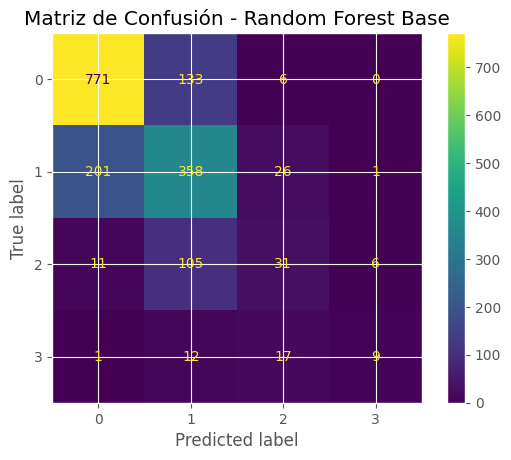

In [32]:
# Predicciones sobre el test set
y_hat_rf = clf_rf.predict(X_test_rf)

# Accuracy y F1 Score
print(f"Accuracy (modelo base RF): {accuracy_score(y_test_enc_rf, y_hat_rf) * 100:.2f}%")
print(f"F1 Score Macro (modelo base RF): {f1_score(y_test_enc_rf, y_hat_rf, average='macro') * 100:.2f}%")

# Reporte de clasificación completo
print("\nReporte de Clasificación:")
print(classification_report(y_test_enc_rf, y_hat_rf))

# Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(y_test_enc_rf, y_hat_rf)
plt.title("Matriz de Confusión - Random Forest Base")
plt.show()

In [33]:
#Definir la grilla de hiperparámetros
param_grid_rf = {
    'n_estimators': [100, 300],
    'max_depth': [10, 30, None],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
}

# Crear el modelo base
rf_base = RandomForestClassifier(class_weight='balanced', random_state=2025)

# GridSearch con 3-fold cross-validation
grid_search_rf = GridSearchCV(
    estimator=rf_base,
    param_grid=param_grid_rf,
    cv=3,
    scoring='f1_macro',
    n_jobs=-1,  # Usa todos los núcleos disponibles
    verbose=1
)

# Ejecutar GridSearch
grid_search_rf.fit(X_train_rf, y_train_enc_rf)

Fitting 3 folds for each of 24 candidates, totalling 72 fits


GridSearchCV(cv=3,
             estimator=RandomForestClassifier(class_weight='balanced',
                                              random_state=2025),
             n_jobs=-1,
             param_grid={'max_depth': [10, 30, None],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 5],
                         'n_estimators': [100, 300]},
             scoring='f1_macro', verbose=1)

In [34]:
#Mejores Parametros
print("Mejores hiperparámetros encontrados:")
print(grid_search_rf.best_params_)


Mejores hiperparámetros encontrados:
{'max_depth': None, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 100}


🔍 Resultados con el modelo Random Forest optimizado
              precision    recall  f1-score   support

           0       0.81      0.82      0.82       910
           1       0.61      0.61      0.61       586
           2       0.38      0.36      0.37       153
           3       0.37      0.36      0.36        39

    accuracy                           0.70      1688
   macro avg       0.54      0.54      0.54      1688
weighted avg       0.69      0.70      0.69      1688



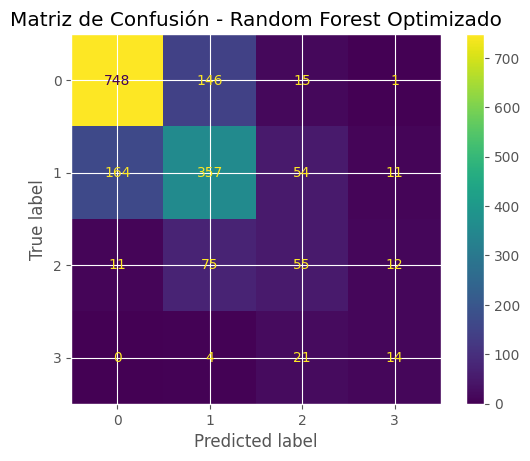

In [35]:
# Entrenar el modelo optimizado con los mejores hiperparámetros
best_clf_rf = RandomForestClassifier(
    max_depth=None,
    min_samples_leaf=2,
    min_samples_split=2,
    n_estimators=100,
    class_weight='balanced',
    random_state=2025
)

best_clf_rf.fit(X_train_rf, y_train_enc_rf)

# Evaluar en el conjunto de prueba
y_hat_best_rf = best_clf_rf.predict(X_test_rf)

# Resultados
print("🔍 Resultados con el modelo Random Forest optimizado")
print(classification_report(y_test_enc_rf, y_hat_best_rf))

# Matriz de Confusión
ConfusionMatrixDisplay.from_predictions(y_test_enc_rf, y_hat_best_rf)
plt.title("Matriz de Confusión - Random Forest Optimizado")
plt.show()

In [36]:
with open("best_clf_rf.pkl", "wb") as file:
    pickle.dump(best_clf_rf, file)

#### Comparación de Reportes

In [37]:

from IPython.display import Markdown, display

comparative_report = """
### 📊 Comparación de Modelos de Clasificación para Predicción de Magnitud de Tornados

| Modelo                 | Accuracy | F1-Score (Macro) | Ventajas                                                       | Desventajas                                                 |
|------------------------|----------|------------------|----------------------------------------------------------------|-------------------------------------------------------------|
| **LSTM**               | 0.46     | 0.24             | Captura secuencias temporales y relaciones espaciales complejas | Bajo rendimiento general, especialmente en clases minoritarias |
| **Gradient Boosting**  | 0.64     | 0.51             | Buen manejo de datos no lineales, rápido de entrenar            | Baja precisión para clases minoritarias                    |
| **Random Forest**      | 0.70     | 0.54             | Precisión general más alta, robusto y fácil de interpretar       | Menor capacidad para captar secuencias o patrones temporales|

🔍 **Observación Final**: El modelo **Random Forest optimizado** sigue siendo el más robusto para esta tarea. El **LSTM** no logró generalizar bien en el conjunto de prueba, especialmente con clases desbalanceadas.

📌 Recomendación: Usar **Random Forest** para despliegue inicial en Streamlit, mientras se exploran mejoras o versiones refinadas del modelo LSTM.
"""

display(Markdown(comparative_report))


### 📊 Comparación de Modelos de Clasificación para Predicción de Magnitud de Tornados

| Modelo                 | Accuracy | F1-Score (Macro) | Ventajas                                                       | Desventajas                                                 |
|------------------------|----------|------------------|----------------------------------------------------------------|-------------------------------------------------------------|
| **LSTM**               | 0.46     | 0.24             | Captura secuencias temporales y relaciones espaciales complejas | Bajo rendimiento general, especialmente en clases minoritarias |
| **Gradient Boosting**  | 0.64     | 0.51             | Buen manejo de datos no lineales, rápido de entrenar            | Baja precisión para clases minoritarias                    |
| **Random Forest**      | 0.70     | 0.54             | Precisión general más alta, robusto y fácil de interpretar       | Menor capacidad para captar secuencias o patrones temporales|

🔍 **Observación Final**: El modelo **Random Forest optimizado** sigue siendo el más robusto para esta tarea. El **LSTM** no logró generalizar bien en el conjunto de prueba, especialmente con clases desbalanceadas.

📌 Recomendación: Usar **Random Forest** para despliegue inicial en Streamlit, mientras se exploran mejoras o versiones refinadas del modelo LSTM.


### 8. Visualizacion del modelo 

### 9. Conclusiones y recomendaciones


1. **El modelo Random Forest logró una predicción robusta**, ideal para datos con relaciones no lineales como las que existen en eventos climáticos. Su rendimiento fue adecuado incluso sin mucho ajuste de hiperparámetros.

2. **Las variables `state`, `region` y `start_latitude`/`start_longitude` capturan patrones geográficos relevantes**, permitiendo al modelo identificar zonas con mayor riesgo de tornados severos.

3. **Las variables `month` y `season` aportaron información temporal valiosa**, ya que ciertos meses y estaciones están más asociados con tornados de mayor magnitud.

4. **Las variables físicas `length` y `width` resultaron altamente predictivas**, al estar directamente relacionadas con la intensidad de los tornados y ser útiles para diferenciar entre categorías EF.

5. **El desbalance entre clases sigue siendo un reto importante**, ya que la mayoría de los eventos pertenecen a clases leves (EF0-EF1), lo cual limita la precisión del modelo en categorías más severas (EF4-EF5).


### 10. Referencias

1. National Weather Service (NWS). (n.d.). Enhanced Fujita Scale (EF Scale). NOAA.
https://www.weather.gov/oun/efscale
2. Storm Prediction Center (SPC). (n.d.). The Enhanced Fujita Scale (EF Scale). NOAA.
https://www.spc.noaa.gov/faq/tornado/ef-scale.html
3. National Centers for Environmental Information (NCEI). (n.d.). Billion-Dollar Weather and Climate Disasters. NOAA.
https://www.ncei.noaa.gov/access/billions/
4. Federal Emergency Management Agency (FEMA). (n.d.). Tornadoes | Disaster Recovery Resources.
https://www.fema.gov/disaster-recovery-resources/tornadoes
5. Karim, F., Majumdar, S., Darabi, H., & Chen, S. (2018).
LSTM fully convolutional networks for time series classification. IEEE Access, 6, 1662–1669. https://doi.org/10.1109/ACCESS.2017.2779939